# Sentiment Analysis on Movie Reviews

## Importing Libraries

In [1]:
# Data retrieval
import tarfile

# Preprocessing
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk.corpus import stopwords, wordnet
from nltk.stem.snowball import SnowballStemmer
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectPercentile

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import pickle

In [2]:
RANDOM_SEED=42

## Importing Data

In [3]:
filename = "data/imbd_dataset.tar.gz"
def load_data(directory, sentiment):
    """
    Reads the raw training and testing data from the downloaded dataset.
    """
    with tarfile.open(filename, mode="r:gz") as tar:
        reviews = []
        for member in tar.getmembers():
            f = tar.extractfile(member)
            if member.name.startswith(directory): 
                if f is not None:
                    reviews.append(f.read().decode())
    return pd.DataFrame({'review': reviews,'sentiment': sentiment})

# Load training data 
pos_train_df = load_data("aclImdb/train/pos", 1)
neg_train_df = load_data( "aclImdb/train/neg", 0)
    
# Load testing data
pos_test_df = load_data("aclImdb/test/pos", 1)
neg_test_df = load_data("aclImdb/test/neg", 0)
    
# Merge the negative and positive train datasets and shuffle the resultant records
train_df = pd.concat([pos_train_df, neg_train_df,pos_test_df,neg_test_df], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df.head()

,review,sentiment
0,The very first talking picture has returned fr...,1
1,Much to your presumable happiness fair readers...,1
2,"There are no people like ""Show People"" Marion ...",1
3,"OK, this movie starts out like a cheesy Lifeti...",1
4,Pretty visuals and a lot of fights make not a ...,0


## Data Pre-procesiing

In [ ]:
# Check if there are duplicated reviews
print(f'number of samples:{len(train_df.review)}')
print(f'number of unique reviews: {train_df.review.nunique()}')
print(f'percentage of duplicates: {(len(train_df.review) - train_df.review.nunique()) / len(train_df.review)*100}%')
train_df[train_df.duplicated(['review'], keep=False)].sort_values(by='review')

number of samples:50000
number of unique reviews: 49582
percentage of duplicates: 0.836%


,review,sentiment
32513,"""Go Fish"" garnered Rose Troche rightly or wron...",0
23057,"""Go Fish"" garnered Rose Troche rightly or wron...",0
28198,"""Three"" is a seriously dumb shipwreck movie. M...",0
4384,"""Three"" is a seriously dumb shipwreck movie. M...",0
10677,"""Witchery"" might just be the most incoherent a...",0
...,...,...
24625,this movie sucks. did anyone notice that the e...,0
4172,"well, the writing was very sloppy, the directi...",0
16200,"well, the writing was very sloppy, the directi...",0
21510,"when I first heard about this movie, I noticed...",1


In [4]:
# Remove duplicates
train_df = train_df.drop_duplicates(keep="first")
train_df.index = range(len(train_df.index))

In [ ]:
example=train_df['review'][87]
print(example)

Never mind the serious logic gaps, never mind the achingly cliche character portrayals, never mind the haphazard writing, and you might like this movie. The main character Alyssa was supposed to be endearing, the heroine who you root for to be saved,(or in this case, save herself) But instead she merely grates, and makes one wonder, are all pro ballerinas really that stupid? Her busybody mother was obviously only necessary to further propagate the illusion that ballet companies are evil monsters ready to snatch your poor, innocent, young girl from your grasp, with an ever present, biting artistic director/villain. And the cliche's! Not only does she become anorexic, bulemic, an over the counter junkie, and a pathological liar, but all in the course of a few months. It's like the writer read every horror story he could dig up about ballet and decided to see how much he could cram into two hours, (with commercials).<br /><br />Believe it or not, but I am a dancer. This "uprising" or "res

In [5]:
stop_words = set(stopwords.words('english'))
not_remove = set(['no', 'not', 'nor']) 
stop_words = stop_words - not_remove

# Clean the data
def convert_emoticons(text):
    """Converts emoticons to text."""
    for emot in EMOTICONS_EMO:
        text =text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
    return text

def convert_emojis(text):
    """Converts emojisto text."""
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, " ".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

def decontrac(text):
    """Converts contraction to its expanded version."""
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    return text

def clean_text(text):
    """
    Performs fundamental actions to clean the text, including transforming all the text to lowercase, 
    eliminating characters that do not qualify as words or whitespace, as well as removing any numerical digits present.

    Args:
        text (str): raw string.

    Returns:
        text (str): cleaned string.
    """  
    text = re.sub(re.compile('<.*?>'), '', text) # Remove HTML tags
    url_pattern = re.compile(r'https?://\S+|www\.\S+') # Remove URLs
    text = url_pattern.sub('', text)
    text = decontrac(text) # Expand contractions
    text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',text)
    text = convert_emojis(text) # Convert emojis to text
    text = convert_emoticons(text) # Convert emoticons to text
    text = text.lower() # Lowercase 
    text = re.sub('[^a-zA-Z]', ' ', text) # Remove punctuations and numbers   
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces  
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # Remove single characters
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*') # Remove stopwords
    text = pattern.sub('', text)   
    text = unidecode(text) # Remove accents
    return text

In [ ]:
example=clean_text(example)
print(example)

never mind serious logic gaps never mind achingly cliche character portrayals never mind haphazard writing might like movie main character alyssa supposed endearing heroine root saved case save instead merely grates makes one wonder pro ballerinas really stupid busybody mother obviously necessary propagate illusion ballet companies evil monsters ready snatch poor innocent young girl grasp ever present biting artistic director villain cliche not become anorexic bulemic counter junkie pathological liar course months like writer read every horror story could dig ballet decided see much could cram two hours commercials believe not dancer uprising resurgence anorexia bulemia happening nonexistent dance schools attended fact teachers scared even suggest girl might stand better chance pounds lighter dancers classes would actually considered minorly overweight not saying eating disorders never occur not extent portrayed movie another annoying problem movie means end writing style boyfriend pro

In [6]:
sno = SnowballStemmer(language='english')

def tokenizer_stemmer(text):
    return [sno.stem(word) for word in text.split()]

In [ ]:
example=tokenizer_stemmer(example)
print(example)

['never', 'mind', 'serious', 'logic', 'gap', 'never', 'mind', 'ach', 'clich', 'charact', 'portray', 'never', 'mind', 'haphazard', 'write', 'might', 'like', 'movi', 'main', 'charact', 'alyssa', 'suppos', 'endear', 'heroin', 'root', 'save', 'case', 'save', 'instead', 'mere', 'grate', 'make', 'one', 'wonder', 'pro', 'ballerina', 'realli', 'stupid', 'busybodi', 'mother', 'obvious', 'necessari', 'propag', 'illus', 'ballet', 'compani', 'evil', 'monster', 'readi', 'snatch', 'poor', 'innoc', 'young', 'girl', 'grasp', 'ever', 'present', 'bite', 'artist', 'director', 'villain', 'clich', 'not', 'becom', 'anorex', 'bulem', 'counter', 'junki', 'patholog', 'liar', 'cours', 'month', 'like', 'writer', 'read', 'everi', 'horror', 'stori', 'could', 'dig', 'ballet', 'decid', 'see', 'much', 'could', 'cram', 'two', 'hour', 'commerci', 'believ', 'not', 'dancer', 'upris', 'resurg', 'anorexia', 'bulemia', 'happen', 'nonexist', 'danc', 'school', 'attend', 'fact', 'teacher', 'scare', 'even', 'suggest', 'girl', '

In [ ]:
# Initialize vectorizer
vectorizer = TfidfVectorizer(
                     lowercase=False,   # Already taken care of by tokenizer_stemmer function
                     preprocessor=clean_text, 
                     tokenizer=tokenizer_stemmer,
                     ngram_range=(1,2)
                     )

In [7]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    train_df['review'], 
    train_df['sentiment'], 
    test_size=0.20, 
    random_state=RANDOM_SEED,
)

In [ ]:
# Vectorize the dataset
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train_vec.shape

(39665, 2212562)

Text(0.5, 0, '$\\chi^2$')

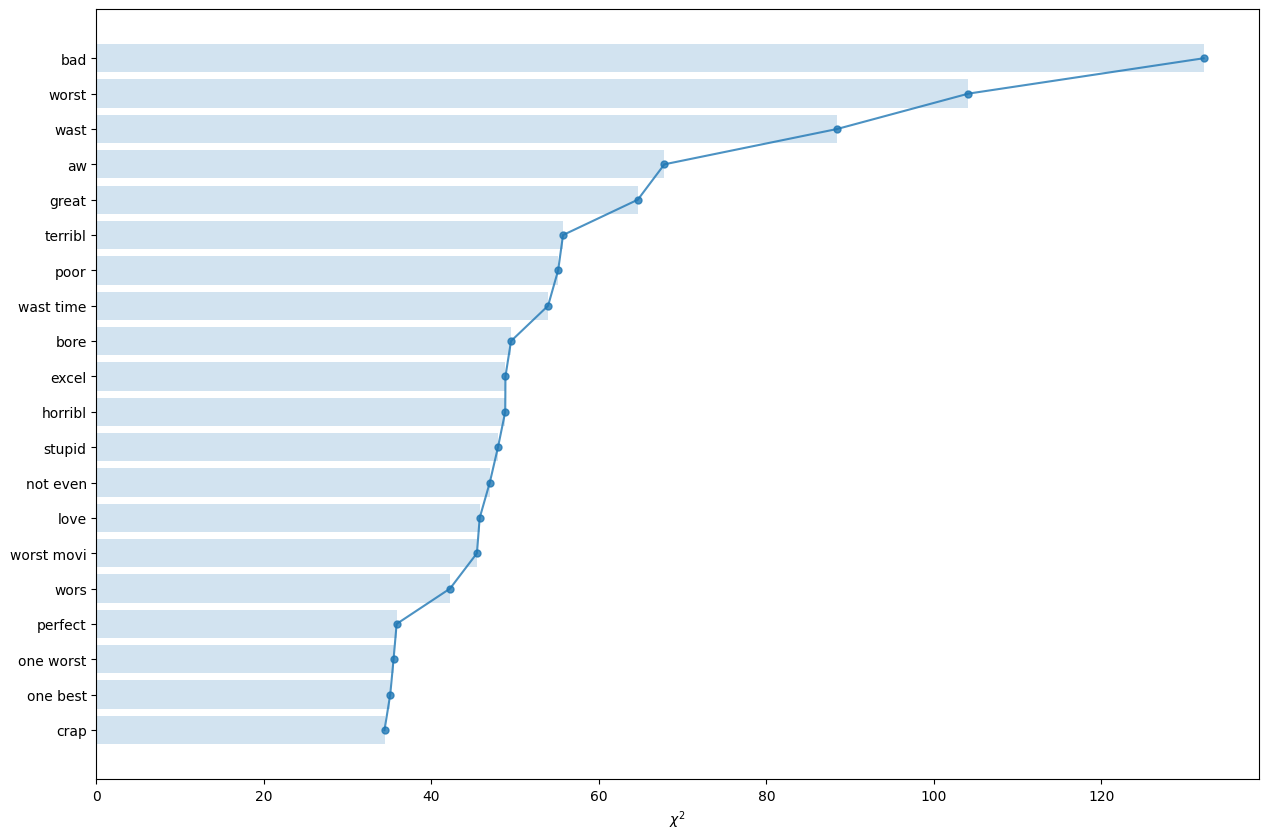

In [ ]:
chi2score = chi2(X_train_vec, y_train)[0]

plt.figure(figsize=(15,10))
wscores = list(zip(vectorizer.get_feature_names_out(), chi2score))
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

## Training

In [8]:
def report(results, n_top=3):
    """Prints classification metrics during the grid search with cross-validation"""
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [9]:
def clf_metrics(y_pred, y_prob):
    """
    Prints classification metrics such as confusion matrics, precision, recall, accuracy, f1-score, roc-curve.

    Args:
        y_pred (ndarray): predictions of a model
        y_prob (ndarray):  predicted probabilities
    """
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}".format(acc*100),end='\n\n')

    # Confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    print('Confusion Matrix:\n', cm)

    # Classification report
    print(classification_report(y_test,y_pred,digits=4))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc='lower right')

### Logistic Regression

C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 89.01

Confusion Matrix:
 [[4353  604]
 [ 486 4474]]
              precision    recall  f1-score   support

           0     0.8996    0.8782    0.8887      4957
           1     0.8811    0.9020    0.8914      4960

    accuracy                         0.8901      9917
   macro avg     0.8903    0.8901    0.8901      9917
weighted avg     0.8903    0.8901    0.8901      9917

Area under the ROC curve : 0.956891
None


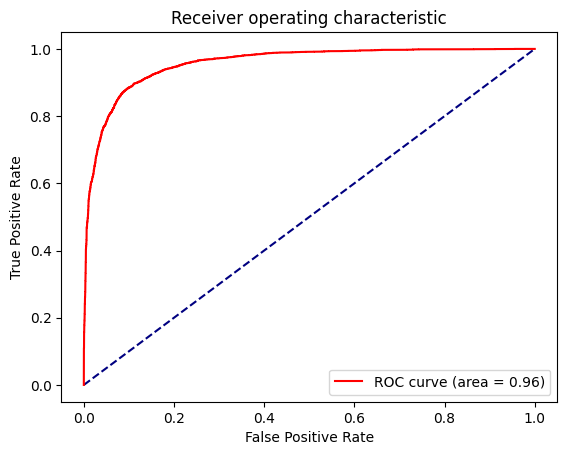

In [ ]:
lr_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('lrg', LogisticRegression(random_state=RANDOM_SEED))
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
y_prob = lr_pipeline.predict_proba(X_test)[:, 1]
print(clf_metrics(y_pred, y_prob))

Applying Grid Search Hyperparameter Tuning & 2-Fold Cross Validation to find the best parameters.

In [ ]:
lr_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(tokenizer=tokenizer_stemmer,preprocessor=clean_text,lowercase=False)),
    ('selector',SelectPercentile(score_func=chi2)),
    ('lrg', LogisticRegression(random_state=RANDOM_SEED))
])

lr_grid_search = GridSearchCV(lr_pipeline, {
    'tfidf__ngram_range': [(1, 2), (1, 1)], 
    'selector__percentile':[25,50,75],
    'lrg__C': [ 1, 5,10]
}, cv=2, verbose=10, n_jobs=-1)

lr_grid_search.fit(X_train, y_train)
report(lr_grid_search.cv_results_, n_top=20)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model with rank: 1
Mean validation score: 0.898 (std: 0.000)
Parameters: {'lrg__C': 10, 'selector__percentile': 25, 'tfidf__ngram_range': (1, 2)}

Model with rank: 2
Mean validation score: 0.898 (std: 0.001)
Parameters: {'lrg__C': 10, 'selector__percentile': 75, 'tfidf__ngram_range': (1, 2)}

Model with rank: 3
Mean validation score: 0.897 (std: 0.000)
Parameters: {'lrg__C': 10, 'selector__percentile': 50, 'tfidf__ngram_range': (1, 2)}

Model with rank: 4
Mean validation score: 0.897 (std: 0.000)
Parameters: {'lrg__C': 5, 'selector__percentile': 25, 'tfidf__ngram_range': (1, 2)}

Model with rank: 5
Mean validation score: 0.896 (std: 0.000)
Parameters: {'lrg__C': 5, 'selector__percentile': 75, 'tfidf__ngram_range': (1, 2)}

Model with rank: 6
Mean validation score: 0.895 (std: 0.000)
Parameters: {'lrg__C': 5, 'selector__percentile': 50, 'tfidf__ngram_range': (1, 2)}

Model with rank: 7
Mean validation score: 0.889 (std: 0.001)
Parameters: {'lrg__C': 5, 'selector__percentile': 50, 'tfidf

C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 90.92

Confusion Matrix:
 [[4455  502]
 [ 398 4562]]
              precision    recall  f1-score   support

           0     0.9180    0.8987    0.9083      4957
           1     0.9009    0.9198    0.9102      4960

    accuracy                         0.9092      9917
   macro avg     0.9094    0.9092    0.9092      9917
weighted avg     0.9094    0.9092    0.9092      9917

Area under the ROC curve : 0.966519
None


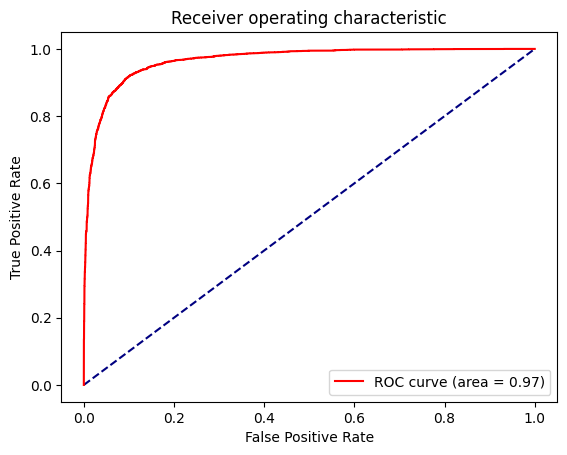

In [ ]:
lr_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(tokenizer=tokenizer_stemmer,preprocessor=clean_text,lowercase=False, ngram_range=(1,2))),
    ('selector',SelectPercentile(score_func=chi2, percentile=25)),
    ('lrg', LogisticRegression(random_state=RANDOM_SEED, C=10))
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
y_prob = lr_pipeline.predict_proba(X_test)[:, 1]
print(clf_metrics(y_pred, y_prob))

The results of the optimized model outperform the initial model with an accuracy score of 90.92 compared to 89.01 prior

### Multinomial Naive Bayes

C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 85.53

Confusion Matrix:
 [[4241  716]
 [ 719 4241]]
              precision    recall  f1-score   support

           0     0.8550    0.8556    0.8553      4957
           1     0.8556    0.8550    0.8553      4960

    accuracy                         0.8553      9917
   macro avg     0.8553    0.8553    0.8553      9917
weighted avg     0.8553    0.8553    0.8553      9917

Area under the ROC curve : 0.929289
None


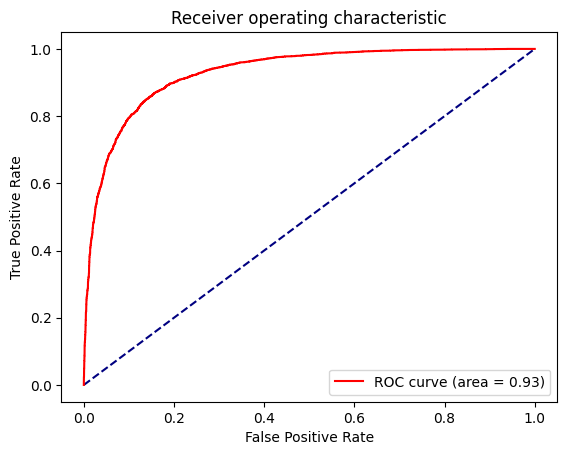

In [ ]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
y_pred = nb_pipeline.predict(X_test)
y_prob = nb_pipeline.predict_proba(X_test)[:, 1]
print(clf_metrics(y_pred, y_prob))

Applying Grid Search Hyperparameter Tuning & 2-Fold Cross Validation to find the best parameters.

In [ ]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenizer_stemmer,preprocessor=clean_text,lowercase=False)),
    ('selector',SelectPercentile(score_func=chi2)),
    ('nb', MultinomialNB())
])

nb_grid_search = GridSearchCV(nb_pipeline, {
    'tfidf__ngram_range': [(1, 2), (1, 1)], 
    'selector__percentile':[25,50,75],
    'nb__alpha': [0.5, 1, 10]
}, cv=2, verbose=10, n_jobs=-1)

nb_grid_search.fit(X_train, y_train)
report(nb_grid_search.cv_results_, n_top=20)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model with rank: 1
Mean validation score: 0.884 (std: 0.002)
Parameters: {'nb__alpha': 0.5, 'selector__percentile': 50, 'tfidf__ngram_range': (1, 2)}

Model with rank: 2
Mean validation score: 0.884 (std: 0.002)
Parameters: {'nb__alpha': 0.5, 'selector__percentile': 75, 'tfidf__ngram_range': (1, 2)}

Model with rank: 3
Mean validation score: 0.883 (std: 0.002)
Parameters: {'nb__alpha': 0.5, 'selector__percentile': 25, 'tfidf__ngram_range': (1, 2)}

Model with rank: 4
Mean validation score: 0.882 (std: 0.002)
Parameters: {'nb__alpha': 1, 'selector__percentile': 50, 'tfidf__ngram_range': (1, 2)}

Model with rank: 5
Mean validation score: 0.881 (std: 0.002)
Parameters: {'nb__alpha': 1, 'selector__percentile': 25, 'tfidf__ngram_range': (1, 2)}

Model with rank: 6
Mean validation score: 0.881 (std: 0.002)
Parameters: {'nb__alpha': 1, 'selector__percentile': 75, 'tfidf__ngram_range': (1, 2)}

Model with rank: 7
Mean validation score: 0.868 (std: 0.000)
Parameters: {'nb__alpha': 10, 'selector

C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 88.14

Confusion Matrix:
 [[4346  611]
 [ 565 4395]]
              precision    recall  f1-score   support

           0     0.8850    0.8767    0.8808      4957
           1     0.8779    0.8861    0.8820      4960

    accuracy                         0.8814      9917
   macro avg     0.8814    0.8814    0.8814      9917
weighted avg     0.8814    0.8814    0.8814      9917

Area under the ROC curve : 0.949865
None


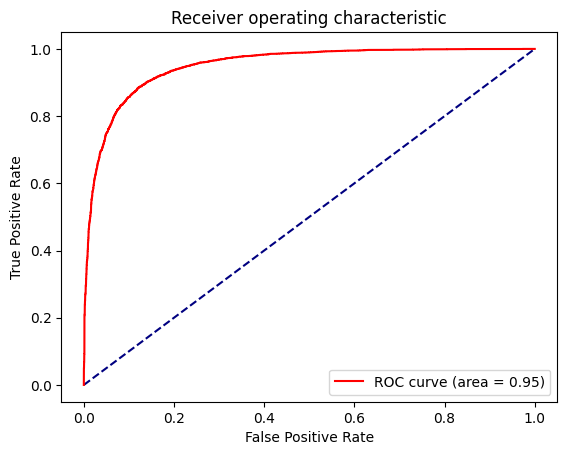

In [ ]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenizer_stemmer,preprocessor=clean_text,lowercase=False, ngram_range=(1,2))),
    ('selector',SelectPercentile(score_func=chi2, percentile=50)),
    ('nb', MultinomialNB(alpha=0.5))
])

nb_pipeline.fit(X_train, y_train)
y_pred = nb_pipeline.predict(X_test)
y_prob = nb_pipeline.predict_proba(X_test)[:, 1]
print(clf_metrics(y_pred, y_prob))

The results of the optimized model outperform the initial model with an accuracy score of 88.11 compared to 85.53 prior

### Support Vector Machine

C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 89.28

Confusion Matrix:
 [[4364  593]
 [ 470 4490]]
              precision    recall  f1-score   support

           0     0.9028    0.8804    0.8914      4957
           1     0.8833    0.9052    0.8942      4960

    accuracy                         0.8928      9917
   macro avg     0.8931    0.8928    0.8928      9917
weighted avg     0.8931    0.8928    0.8928      9917

Area under the ROC curve : 0.958026
None


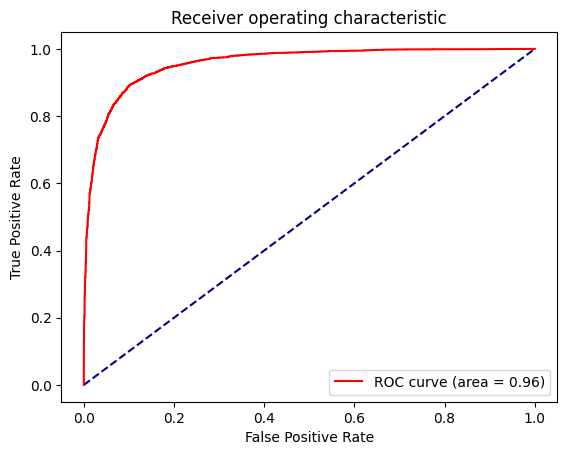

In [ ]:
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(random_state=RANDOM_SEED, kernel='linear'))
])

svc_pipeline.fit(X_train, y_train)
y_pred = svc_pipeline.predict(X_test)
y_prob = svc_pipeline.decision_function(X_test)
print(clf_metrics(y_pred, y_prob))

Applying Grid Search Hyperparameter Tuning & 2-Fold Cross Validation to find the best parameters.

In [ ]:
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenizer_stemmer,preprocessor=clean_text,lowercase=False)),
    ('selector',SelectPercentile(score_func=chi2)),
    ('svc', SVC(random_state=RANDOM_SEED, kernel='linear'))
])

svc_grid_search = GridSearchCV(svc_pipeline, {
    'tfidf__ngram_range': [(1, 1), (1, 2)], 
    'selector__percentile':[25,50,75],
    'svc__C': [0.1, 1, 10]
}, cv=2, verbose=10, n_jobs=-1)

svc_grid_search.fit(X_train, y_train)
report(svc_grid_search.cv_results_, n_top=20)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model with rank: 1
Mean validation score: 0.902 (std: 0.001)
Parameters: {'selector__percentile': 75, 'svc__C': 10, 'tfidf__ngram_range': (1, 2)}

Model with rank: 2
Mean validation score: 0.899 (std: 0.001)
Parameters: {'selector__percentile': 75, 'svc__C': 1, 'tfidf__ngram_range': (1, 2)}

Model with rank: 3
Mean validation score: 0.899 (std: 0.001)
Parameters: {'selector__percentile': 50, 'svc__C': 1, 'tfidf__ngram_range': (1, 2)}

Model with rank: 4
Mean validation score: 0.898 (std: 0.001)
Parameters: {'selector__percentile': 50, 'svc__C': 10, 'tfidf__ngram_range': (1, 2)}

Model with rank: 5
Mean validation score: 0.898 (std: 0.000)
Parameters: {'selector__percentile': 25, 'svc__C': 1, 'tfidf__ngram_range': (1, 2)}

Model with rank: 6
Mean validation score: 0.896 (std: 0.001)
Parameters: {'selector__percentile': 25, 'svc__C': 10, 'tfidf__ngram_range': (1, 2)}

Model with rank: 7
Mean validation score: 0.888 (std: 0.000)
Parameters: {'selector__percentile': 50, 'svc__C': 1, 'tfidf

C:\Users\пк\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 90.78

Confusion Matrix:
 [[4462  495]
 [ 419 4541]]
              precision    recall  f1-score   support

           0     0.9142    0.9001    0.9071      4957
           1     0.9017    0.9155    0.9086      4960

    accuracy                         0.9078      9917
   macro avg     0.9079    0.9078    0.9078      9917
weighted avg     0.9079    0.9078    0.9078      9917

Area under the ROC curve : 0.965350
None


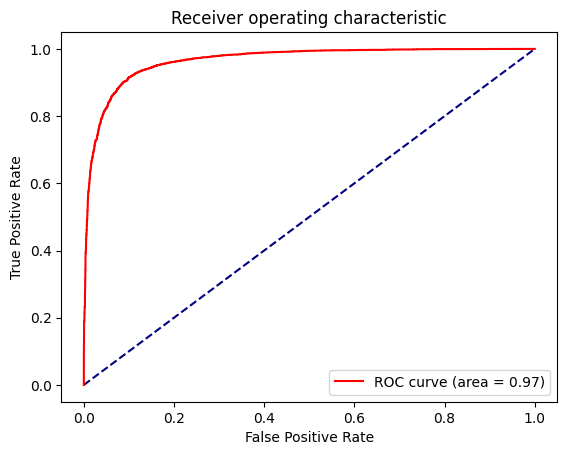

In [ ]:
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenizer_stemmer,preprocessor=clean_text,lowercase=False, ngram_range=(1,2))),
    ('selector',SelectPercentile(score_func=chi2, percentile=75)),
    ('svc', SVC(random_state=RANDOM_SEED, kernel='linear', C=10))
])

svc_pipeline.fit(X_train, y_train)
y_pred = svc_pipeline.predict(X_test)
y_prob = svc_pipeline.decision_function(X_test)
print(clf_metrics(y_pred, y_prob))


The results of the optimized model outperform the initial model with an accuracy score of 90.78 compared to 89.28 prior 

In [ ]:
# Save the model to a file
with open('models/lr_model.pkl', 'wb') as file:
    pickle.dump(lr_grid_search, file)

with open('models/nb_model.pkl', 'wb') as file:
    pickle.dump(nb_grid_search, file)

with open('models/svc_model.pkl', 'wb') as file:
    pickle.dump(svc_grid_search, file)

## Testing trained models on different datasets

In [10]:
# Load the model from the file
with open('models/lr_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)

with open('models/nb_model.pkl', 'rb') as f:
    nb_model = pickle.load(f)

with open('models/svc_model.pkl', 'rb') as f:
    svc_model = pickle.load(f)

### Cornel Movie Reviews

In [11]:
filename = "data/cornel_movie_review.tar.gz"
# Load training data 
pos_train_df = load_data("txt_sentoken/pos", 1)
neg_train_df = load_data( "txt_sentoken/neg", 0)

# Merge the negative and positive train datasets and shuffle the resultant records
df = pd.concat([pos_train_df, neg_train_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df

,review,sentiment
0,i guess that if a very wild bachelor party had...,0
1,"with the abundance of trite , recycled movies ...",1
2,"as a hot-shot defense attorney , kevin lomax (...",0
3,hedwig ( john cameron mitchell ) was born a bo...,1
4,"i've heard it called "" jaws with claws "" and t...",0
...,...,...
1995,"i never understood what the clich ? "" hell on ...",0
1996,in this re-make of the 1954 japanese monster f...,0
1997,the verdict : spine-chilling drama from horror...,1
1998,""" . . . because i'm a scientist . \nthat's wh...",0


In [ ]:
X_test, y_test = df['review'], df['sentiment']
# Use the linear regression model
y_pred_loaded = lr_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 88.2 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1000
           1       0.88      0.89      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
X_test, y_test = df['review'], df['sentiment']
# Use the Naive Bayes model
y_pred_loaded = nb_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 83.35000000000001 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1000
           1       0.82      0.86      0.84      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [ ]:
X_test, y_test = df['review'], df['sentiment']
# Use the SVM model 
y_pred_loaded = svc_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 88.05 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1000
           1       0.88      0.88      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



### Rotten Tomatoes Reviews

In [ ]:
# Read data
reviews_df = pd.read_csv("data/rt_movie_review.csv")
reviews_df

,reviews,labels
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0
...,...,...
10657,both exuberantly romantic and serenely melanch...,1
10658,mazel tov to a film about a family's joyous li...,1
10659,standing in the shadows of motown is the best ...,1
10660,it's nice to see piscopo again after all these...,1


In [ ]:
X_test, y_test = reviews_df['reviews'], reviews_df['labels']
# Use the linear regression model
y_pred_loaded = lr_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 74.1418120427687 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73      5331
           1       0.72      0.78      0.75      5331

    accuracy                           0.74     10662
   macro avg       0.74      0.74      0.74     10662
weighted avg       0.74      0.74      0.74     10662



In [ ]:
X_test, y_test = reviews_df['reviews'], reviews_df['labels']
# Use the Naive Bayes model
y_pred_loaded = nb_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 75.29544175576814 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73      5331
           1       0.72      0.82      0.77      5331

    accuracy                           0.75     10662
   macro avg       0.76      0.75      0.75     10662
weighted avg       0.76      0.75      0.75     10662



In [ ]:
X_test, y_test = reviews_df['reviews'], reviews_df['labels']
# Use the SVM model 
y_pred_loaded = svc_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 74.02926280247608 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73      5331
           1       0.73      0.77      0.75      5331

    accuracy                           0.74     10662
   macro avg       0.74      0.74      0.74     10662
weighted avg       0.74      0.74      0.74     10662



### SAR14

In [ ]:
df = pd.read_csv('data/SAR14.txt',header=None,names=['reviews','labels'])
df=df.replace({1: 0, 2: 0, 3:0, 4:0, 7:1, 8:1, 9:1, 10:1})
df

,reviews,labels
0,The first art-film ? . this is possibly the m...,1
1,collision between the tradition of family val...,1
2,An everyday occurrence for posterity . Louis ...,0
3,The first family film ? . Monsieur Lumi re no...,0
4,Ouch ! That 's Got ta Hurt ! -LRB- SPOILERS -...,1
...,...,...
233595,Without the king . The trailer for the film l...,1
233596,with a king . I watched your documentary sir ...,0
233597,What was the casting dept thinking ?? . Well ...,0
233598,This could be a `` so '' good movie . What fi...,0


In [ ]:
X_test, y_test = df['reviews'], df['labels']
# Use the linear regression model
y_pred_loaded = lr_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 89.52482876712328 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83     66222
           1       0.96      0.89      0.92    167378

    accuracy                           0.90    233600
   macro avg       0.86      0.90      0.88    233600
weighted avg       0.91      0.90      0.90    233600



In [ ]:
X_test, y_test = df['reviews'], df['labels']
# Use the Naive Bayes model
y_pred_loaded = nb_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 84.58518835616438 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77     66222
           1       0.96      0.82      0.88    167378

    accuracy                           0.85    233600
   macro avg       0.81      0.86      0.83    233600
weighted avg       0.88      0.85      0.85    233600



In [ ]:
X_test, y_test = df['reviews'], df['labels']
# Use the SVM model 
y_pred_loaded = svc_model.predict(X_test)
# Evaluate the model
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded)*100, "%")
print("Loaded Model Classification Report:\n", classification_report(y_test, y_pred_loaded))

Loaded Model Accuracy: 89.43792808219177 %
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83     66222
           1       0.96      0.89      0.92    167378

    accuracy                           0.89    233600
   macro avg       0.86      0.90      0.88    233600
weighted avg       0.91      0.89      0.90    233600



Logistic regression model has achieved better results when comparing to the other models. Hence, we will use it to analyze movie reviews and determine the overall sentiment towards the movie. 

## Predicting Overall Sentiment with Logistic Regression

In [ ]:
# Read data
reviews_df = pd.read_csv("data/letterboxd-reviews.csv",encoding='ISO-8859-1',on_bad_lines='skip')
reviews_df=reviews_df.dropna(subset=['Review']) # drop nan values
reviews_df.head(5)

,Movie name,Release Year,Rating,Reviewer name,Review date,Review,Comment count,Like count
0,Aftersun (2022),2022,â??â??â??â??Â½,Tuomas,12-Jan-20,This review may contain spoilers.,130,"22,44 6 likes"
1,Joker (2019),2019,â??â??â??â??â??,Joao,20-Dec-22,if youâ??ve never swam in the ocean then of course a pool seems deep.,1.8K,"22,032 likes"
2,Puss in Boots: The Last Wish (2022),2022,â??Â½,NicoPico,15-Sep-22,Puss in Boots: Into the Pussy-Verse,6 2,"21, 6 6 6 likes"
3,The Banshees of Inisherin (2022),2022,â??â??â??â??â??,Ella Kemp,8-Apr-22,I will NOT leave my donkey outside when Iâ??m sad,NaN,"21, 6 09 likes"
4,Everything Everywhere All at Once (2022),2022,â??â??Â½,CosmonautMarkie,14-Aug-19,Watch it and have fun before film Twitter tells you itâ??s overrated,355,"20, 6 88 likes"


In [ ]:
# Predict on the data
reviews_df['sentiment'] = lr_model.predict(reviews_df['Review'].astype('U').values)
reviews_df.head(5)

,Movie name,Release Year,Rating,Reviewer name,Review date,Review,Comment count,Like count,sentiment
0,Aftersun (2022),2022,â??â??â??â??Â½,Tuomas,12-Jan-20,This review may contain spoilers.,130,"22,44 6 likes",0
1,Joker (2019),2019,â??â??â??â??â??,Joao,20-Dec-22,if youâ??ve never swam in the ocean then of course a pool seems deep.,1.8K,"22,032 likes",1
2,Puss in Boots: The Last Wish (2022),2022,â??Â½,NicoPico,15-Sep-22,Puss in Boots: Into the Pussy-Verse,6 2,"21, 6 6 6 likes",1
3,The Banshees of Inisherin (2022),2022,â??â??â??â??â??,Ella Kemp,8-Apr-22,I will NOT leave my donkey outside when Iâ??m sad,NaN,"21, 6 09 likes",0
4,Everything Everywhere All at Once (2022),2022,â??â??Â½,CosmonautMarkie,14-Aug-19,Watch it and have fun before film Twitter tells you itâ??s overrated,355,"20, 6 88 likes",1


In [ ]:
# Select film to analyse
pd.set_option('display.max_colwidth', None) 
film_name='Dune (2021)'
reviews_df[reviews_df['Movie name'] == film_name]

,Movie name,Release Year,Rating,Reviewer name,Review date,Review,Comment count,Like count,sentiment
9,Dune (2021),2021,â??â??â??â??,kÃ¡rsten,9-Aug-19,got the 4D experience by forgetting to drink water today and watching this extremely dehydrated,4,"19, 6 24 likes",1
61,Dune (2021),2021,NaN,cookie,6-Oct-21,at one point a kid in front of me got so bored he started doing a headstand in his seat which would normally be annoying but in this case was the most entertaining part of the movie,49,"14,143 likes",0
326,Dune (2021),2021,â??â??â??â??,molly,19-Sep-21,I relate to paul because i also have recurring dreams about zendaya,13,"6 ,985 likes",1


In [ ]:
df = reviews_df.groupby('Movie name')['sentiment'].agg(['sum','size']) 
df = df.reset_index()
df['overall sentiment'] = round(df['sum']/df['size']) # Determine he overall sentiment
    
print(f"The overall sentiment towards the {film_name} movie is {df.loc[df['Movie name']==film_name,'overall sentiment'].values[0]}")

The overall sentiment towards the Dune (2021) movie is 1.0


In [ ]:
# Let's select another movie
film_name='Venom: Let There Be Carnage' 
reviews_df[reviews_df['Movie name'] ==  film_name]

,Movie name,Release Year,Rating,Reviewer name,Review date,Review,Comment count,Like count,sentiment
1725,Venom: Let There Be Carnage,2021,â??â??â??â??â??,comrade_yui,NaN,venom LITERALLY said gay rights!!!,6,"3,686 likes",1
2076,Venom: Let There Be Carnage,2021,â??â??â??,Nicole Kubrick ð?³ï¸â?ð???ð?³ï¸â?â?§ï¸,30-Sep-21,More homosexual undertones than The Lighthouse. You think Iâ??m kidding but Iâ??m not.,19,NaN,1
2306,Venom: Let There Be Carnage,2021,â??â??â??,Vinny Simms,1-Oct-21,Venom goes to a gay rave and says heâ??s out of the Eddie closet,6,NaN,0
3967,Venom: Let There Be Carnage,2021,â??â??â??â??,rocky raccoon,30-Sep-21,just watched it. aside from the twelve minute long hardcore gay sex montage with Eddie and Venom it was kinda boring,1,NaN,0


In [ ]:
print(f"The overall sentiment towards the {film_name} movie is {df.loc[df['Movie name']==film_name,'overall sentiment'].values[0]}")

The overall sentiment towards the Venom: Let There Be Carnage movie is 0.0
